In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

from celerite2.jax import terms, GaussianProcess
from gp_model import harmonic_SHO_model
from hls import HarmonicLombScargle
import jax.numpy as jnp
import jax.random as jrn
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from tqdm import tqdm

In [3]:
search_result = lk.search_lightcurve('KIC 5111207')
lcs = [sr.download() for sr in tqdm(search_result)]

100%|██████████| 14/14 [00:00<00:00, 23.61it/s]


In [4]:
times = [lc.time.value for lc in lcs]
fluxes = [lc.flux.value for lc in lcs]
flux_errs = [lc.flux_err.value for lc in lcs]
masks = [~f.mask for f in fluxes]

times = [t[m] for t, m in zip(times, masks)]
fluxes = [f[m] for f, m in zip(fluxes, masks)]
flux_errs = [f[m] for f, m in zip(flux_errs, masks)]

quarters = [float(i)*np.ones_like(t) for (i, t) in enumerate(times)]

times = np.concatenate(times).astype(np.float64)
fluxes = np.array(np.concatenate(fluxes).astype(np.float64))
flux_errs = np.array(np.concatenate(flux_errs).astype(np.float64))
quarters = np.concatenate(quarters)

uquarters, quarter_indices = np.unique(quarters, return_inverse=True)

In [5]:
hls = HarmonicLombScargle(times, fluxes, quarters, 3)

In [6]:
fgrid = hls.relative_frequency_grid(0.05)
logls = hls.logl_on_grid(fgrid)

  0%|          | 0/215 [00:00<?, ?it/s]/Users/wfarr/Code/harmonic-lomb-scargle/hls.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, (rss,), _, _ = np.linalg.lstsq(M, self.flux)
100%|██████████| 215/215 [00:02<00:00, 74.00it/s]


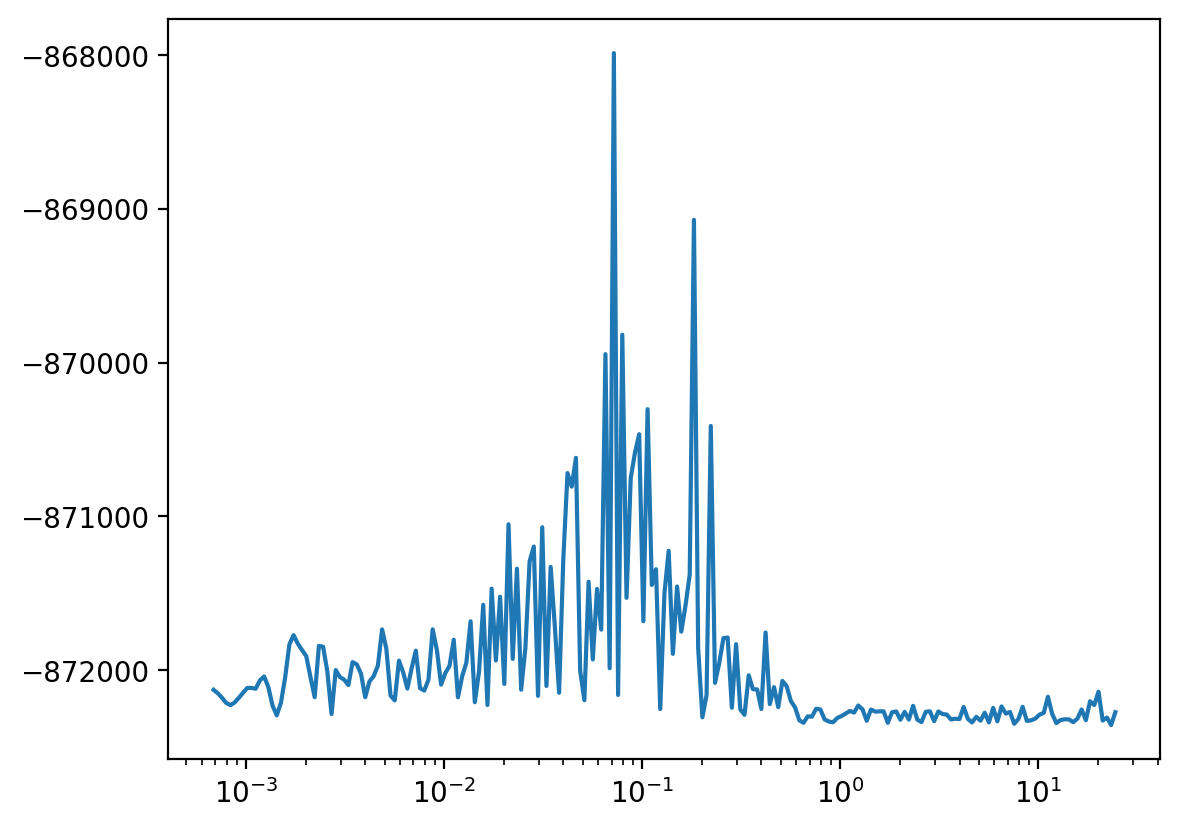

In [7]:
plt.plot(fgrid, logls)
plt.xscale('log')

100%|██████████| 215/215 [00:03<00:00, 57.96it/s]


(1, 100)

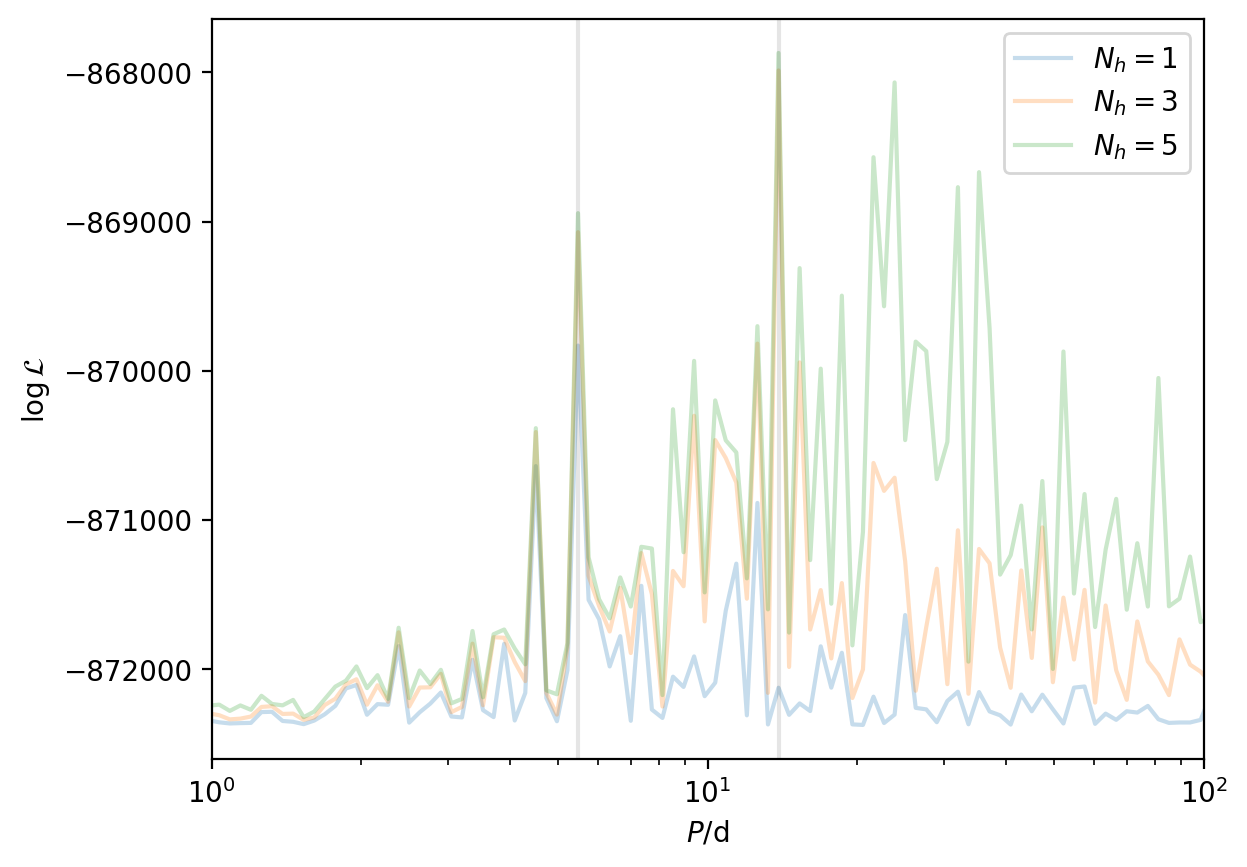

In [8]:
for nh in [1, 3, 5]:
    h = HarmonicLombScargle(times, fluxes, quarters, nh)
    fgrid = h.relative_frequency_grid(0.05)
    logls = h.logl_on_grid(fgrid)
    plt.plot(1/fgrid, logls, label=r'$N_h = {:d}$'.format(nh), alpha=0.25)
plt.xscale('log')
plt.xlabel(r'$P / \mathrm{d}$')
plt.ylabel(r'$\log \mathcal{L}$')
plt.legend()
plt.axvline(5.47, color='k', alpha=0.1)
plt.axvline(13.91, color='k', alpha=0.1)
plt.xlim(1, 100)

In [9]:
f_guess = fgrid[np.argmax(logls)]

fgrid_fine = hls.fine_frequency_grid(f_guess, 128)
logls_fine = hls.logl_on_grid(fgrid_fine)

100%|██████████| 128/128 [00:01<00:00, 71.61it/s]


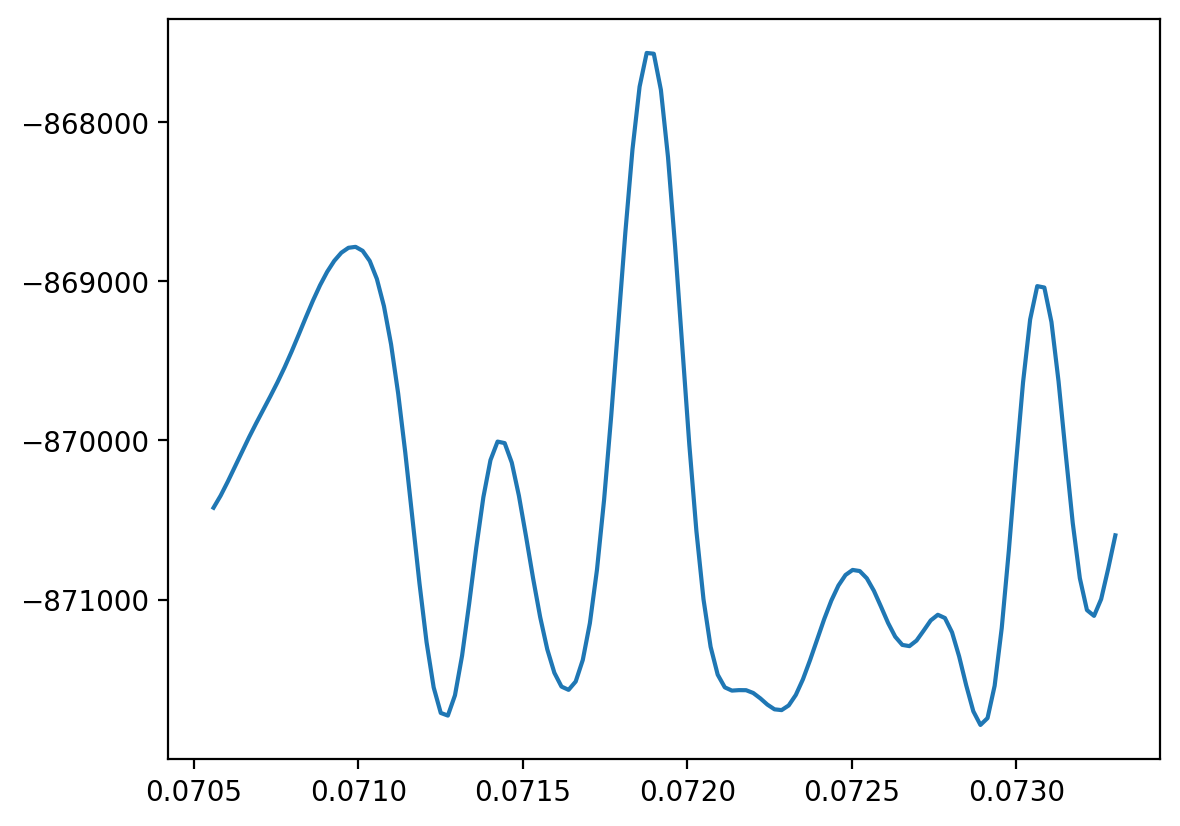

In [10]:
plt.plot(fgrid_fine, logls_fine)

In [11]:
f = hls.interpolated_best_frequency(fgrid_fine, logls_fine)
x_best = hls.best_fit_params(f)

print(f'f_best = {f}/day, or P = {1/f} days')

f_best = 0.07188693293022917/day, or P = 13.910733971229005 days


Text(0, 0.5, 'Residuals [e- / s]')

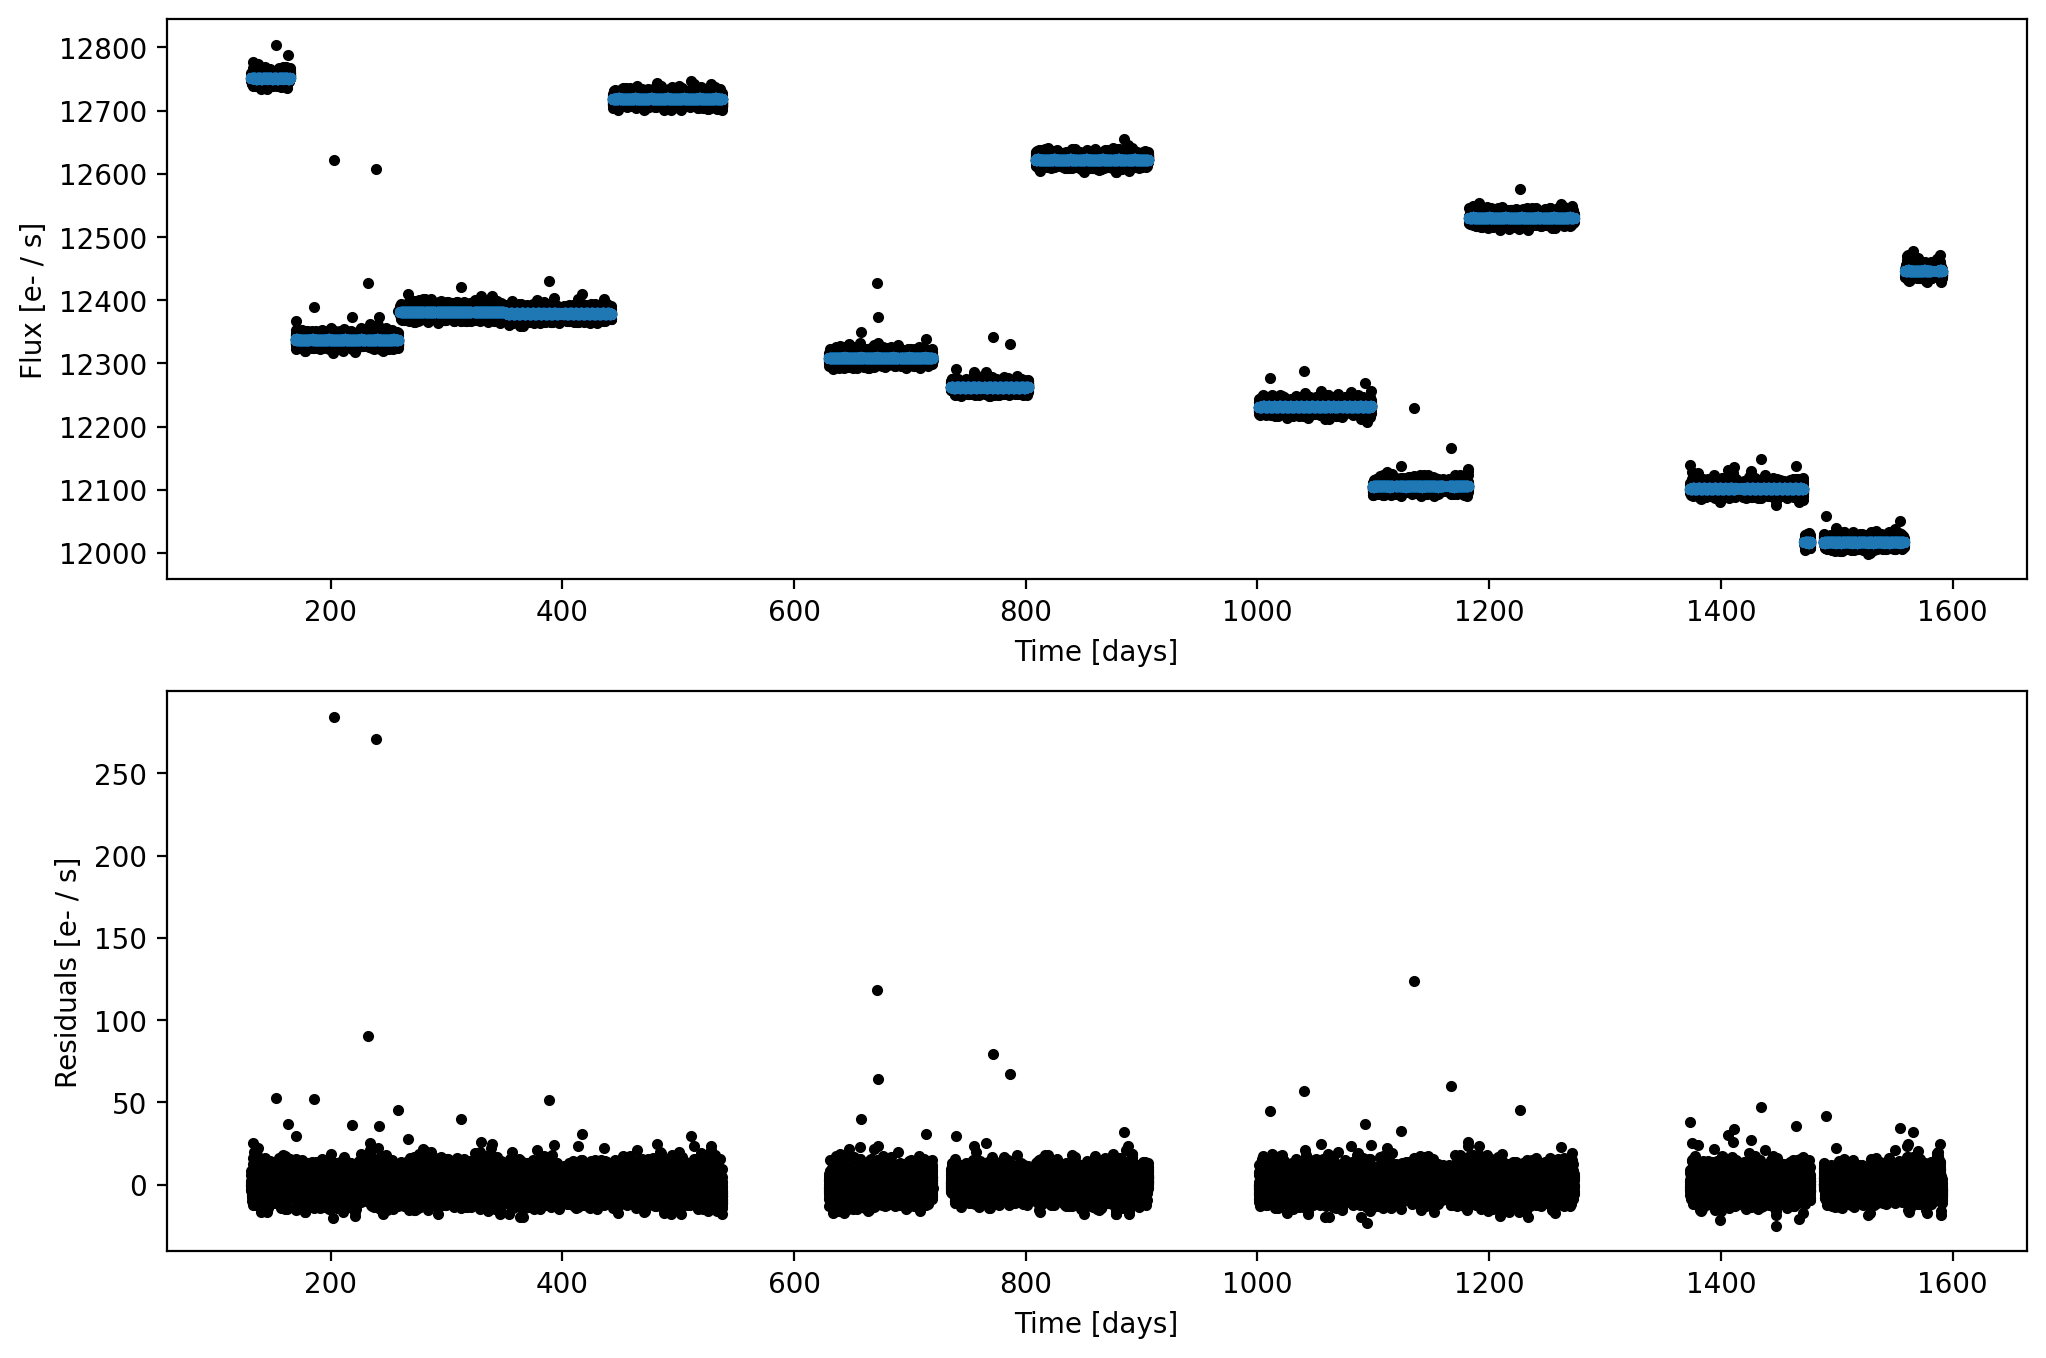

In [12]:
y = hls.predict_flux(f)

fig, subplots = plt.subplots(2, 1, figsize=(12, 8))

subplots[0].plot(times, fluxes, '.k')
subplots[0].plot(times, y, '.')
subplots[0].set_xlabel('Time [days]')
subplots[0].set_ylabel('Flux [e- / s]')

subplots[1].plot(times, fluxes - y, '.k')
subplots[1].set_xlabel('Time [days]')
subplots[1].set_ylabel('Residuals [e- / s]')

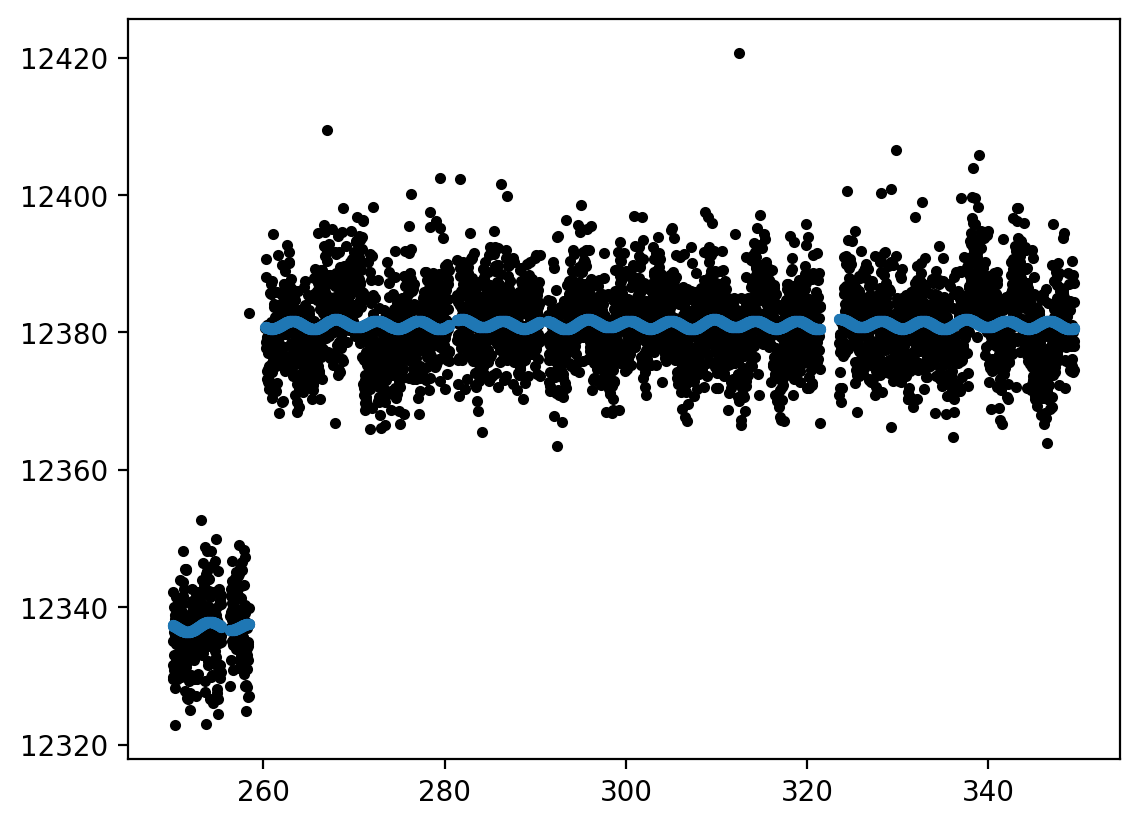

In [13]:
sel = np.abs(times - 300) < 50
plt.plot(times[sel], fluxes[sel], '.k')
plt.plot(times[sel], y[sel], '.')

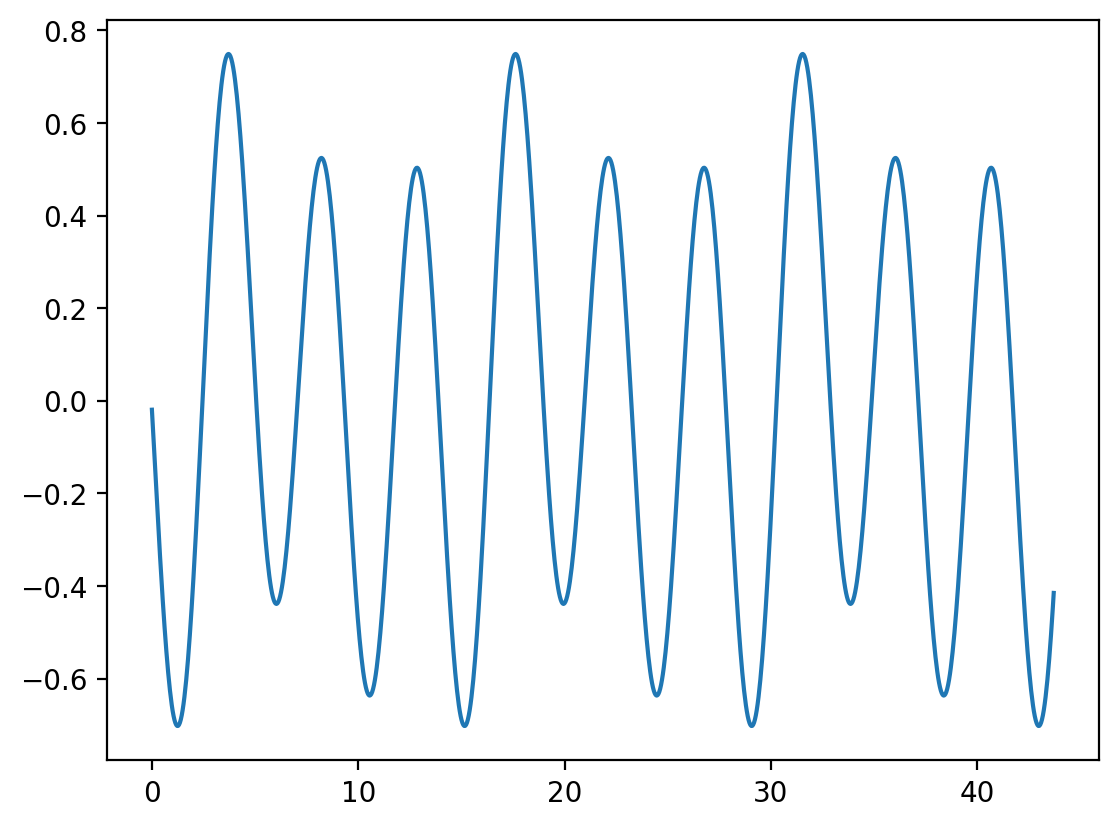

In [14]:
ts = np.linspace(0, np.pi*1/f, 1000)
plt.plot(ts, hls.periodic_lightcurve(ts, f, x_best))

In [16]:
from celerite2.jax import GaussianProcess, terms
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def harmonic_SHO_model(t, y, yerr, yquarters, f0, nharmonics, mu_mu, mu_sigma, sho_sigma_prior, f0_frac_uncert=0.1):
    nquarters = mu_mu.shape[0]

    mus_scaled = numpyro.sample('mus_scaled', dist.Normal(0,1), sample_shape=(nquarters,))
    mus = numpyro.deterministic('mus', mus_scaled * mu_sigma + mu_mu)

    y_centered = y - mus[yquarters]

    log_f0_scaled = numpyro.sample('log_f0_scaled', dist.Normal(0, 1))
    log_f0 = numpyro.deterministic('log_f0', log_f0_scaled*f0_frac_uncert + jnp.log(f0))
    fs = numpyro.deterministic('fs', jnp.exp(log_f0 + jnp.log(jnp.arange(nharmonics) + 1)))

    log_Qs = numpyro.sample('log_Qs', dist.Uniform(jnp.log(1), jnp.log(100)), sample_shape=(nharmonics,))
    Qs = numpyro.deterministic('Qs', jnp.exp(log_Qs))

    sigmas = numpyro.sample('sigmas', dist.LogNormal(jnp.log(sho_sigma_prior), jnp.log(10.0)/2), sample_shape=(nharmonics,))

    trms = [terms.SHOTerm(w0=2*jnp.pi*f*(i+1), Q=10.0, sigma=total_std/np.sqrt(3)) for i in range(nharmonics)]
    kernel = terms.TermSum(*trms)

    gp = GaussianProcess(kernel)
    gp.compute(t, yerr=yerr)
    numpyro.factor('log_likelihood', gp.log_likelihood(y_centered))

In [17]:
n_in_quarters = np.bincount(quarter_indices)
quarter_means = np.bincount(quarter_indices, weights=fluxes) / n_in_quarters
quarter_vars = np.bincount(quarter_indices, weights=(fluxes - quarter_means[quarter_indices])**2) / n_in_quarters
quarter_stds = np.sqrt(quarter_vars)

total_var = np.sum(quarter_vars * n_in_quarters) / np.sum(n_in_quarters)
total_std = np.sqrt(total_var)

In [18]:
kernel = NUTS(harmonic_SHO_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
rng_key = jrn.PRNGKey(np.random.randint(1<<32))

mcmc.run(rng_key, times, fluxes, flux_errs, quarter_indices, f, 1, quarter_means, quarter_stds, total_std)

ValueError: Invalid argument to dtype: None.

In [23]:
def test_gp(t, y, yerr):
    mu = numpyro.sample('mu', dist.Normal(0, 10))
    kernel = terms.UnderdampedSHOTerm(w0=2*np.pi, Q=10, sigma=1.0)
    gp = GaussianProcess(kernel)
    gp.compute(t, yerr=yerr, check_sorted=False)
    numpyro.factor('log_likelihood', gp.log_likelihood(y-mu))

In [24]:
kernel = NUTS(test_gp)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
rng_key = jrn.PRNGKey(np.random.randint(1<<32))
mcmc.run(rng_key, np.arange(100, dtype=np.float64), np.zeros(100), np.ones(100))


ValueError: Invalid argument to dtype: None.